<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics

Para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

    Aluno: **Lucas da S. Rocha**

# Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. O projeto utiliza dados abertos recentes sobre a produção de petróleo e gás no Brasil, fornecidos pela Agência Nacional de Petróleo (ANP). Esses dados, originalmente disponibilizados pela ANP em arquivos separados por mês e por região (terra, mar e pré-sal), foram previamente agrupados e consolidados em um único repositório para facilitar a análise.

Como premissa inicial, este estudo foca exclusivamente em campos offshore (marítimos), buscando simplificar o escopo e alinhar o trabalho com os principais objetivos do setor analisado. A abordagem adotada no MVP visa demonstrar o potencial dos modelos de machine learning para prever a produção futura desses campos com uma granularidade mensal.

# Descrição do problema

O objetivo principal deste trabalho é desenvolver modelos de aprendizado de máquina para prever a produção futura de petróleo, gás e água nos próximos 12 meses, usando dados históricos de produção por campo. Além disso, será demonstrada a curva de produção acumulada projetada.

Premissas e hipóteses principais:

    - Somente campos com produção acumulada superior a 10.000 barris foram utilizados, para remover ruídos causados por campos pequenos e irrelevantes para a análise.
    - Dados foram agregados por campo, com granularidade máxima disponível em nível mensal.
    - Utilizou-se como atributos principais os valores mensais de produção de óleo, gás, água, o tempo de produção em meses e o identificador do campo.

# Metodologia

Os dados foram organizados e preparados da seguinte forma:

  - Divisão dos dados: Dataset separado em conjuntos de treino (70%) e teste (30%). Não foi realizada validação cruzada devido à natureza temporal dos dados, preservando a sequência cronológica para evitar vazamento de informações.

  - Transformações aplicadas:
      Foi realizada a normalização e padronização das variáveis para melhorar a performance dos modelos, especialmente para a rede neural, já que esse tipo de modelo é sensível a escalas diferentes nas variáveis. Para o Gradient Boosting e LightGBM, essas transformações não foram necessárias devido à natureza dos algoritmos, que são menos impactados pela escala das variáveis.

  - Seleção de features:
      Na primeira etapa, foram utilizados apenas o tempo, o campo e a produção de óleo.
      Na etapa de refinamento, incorporaram-se dados de gás e água para melhor performance.

# Modelagem e Treinamento

Modelos treinados para resolver o problema de previsão de produção futura:

  - Regressão Linear: Escolha inicial por ser um modelo simples e interpretável.
  - Gradient Boosting: Explorou padrões complexos nos dados, com boa performance.
  - LightGBM: Excelente para lidar com datasets maiores e atributos adicionais.
  - Rede Neural: Modelo mais avançado, capaz de capturar relações não lineares nos dados.


Ajustes e otimizações:

  Na segunda etapa, os modelos foram ajustados para incluir hiperparâmetros otimizados.
  
  Hyperparameter tuning: Foi aplicado nos melhores modelos (LightGBM e Rede Neural), usando técnicas como busca em grid para maximizar o desempenho usando os parametros ideais.

# Código do MVP

## Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import warnings
import missingno as msno
import re

## Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [ ]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 30)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 145)

# Filter warnings
warnings.filterwarnings('ignore')

## Funções Auxiliares e Variáveis Globais

In [2]:
###################################
####### FUNÇÕES AUXILIARES ########
###################################

def calc_tempo_produzindo(df):
  """
    Calcula o tempo total de produção em meses para cada registro no DataFrame,
    com base no período mínimo de produção registrado por campo.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo informações de produção, incluindo as colunas:
        - 'campo' (identificação do campo de produção)
        - 'periodo' (data do registro de produção, no formato datetime)

    Retorno:
    --------
    pandas.DataFrame
        O DataFrame original com duas novas colunas:
        - 'data_inicio': Data mínima de início de produção por campo.
        - 'tempo_total_producao_meses': Tempo total de produção em meses
          calculado para cada registro desde o início.
    # Encontrar a data mínima de produção por campo
    min_dates = df.groupby('campo')['periodo'].transform('min')  # Transform para alinhar ao DataFrame original
    """

  # Encontrar a data mínima de produção por campo
  min_dates = df.groupby('campo')['periodo'].transform('min')  # Transform para alinhar ao DataFrame original

  # Adicionar a data mínima ao DataFrame original
  df['data_inicio'] = min_dates

  # Calcular o tempo total de produção em meses para cada registro
  df['tempo_total_producao_meses'] = ((df['periodo'].dt.year - df['data_inicio'].dt.year) * 12 +
                                        (df['periodo'].dt.month - df['data_inicio'].dt.month))

  return df


# Função para gerar sequência de meses por campo
def completar_meses(df):
    df_complete = []
    for campo in df['campo'].unique():
        df_campo = df[df['campo'] == campo]

        # Gerar todos os meses do 1 até o máximo de 'tempo_total_producao_meses'
        max_meses = df_campo['tempo_total_producao_meses'].max()
        meses_completos = pd.DataFrame({'tempo_total_producao_meses': np.arange(1, max_meses + 1)})

        # Mesclar com os dados originais e preencher valores ausentes
        df_campo_completo = pd.merge(meses_completos,
                                     df_campo,  # Inclui todas as colunas do df original
                                     how='left',
                                     on='tempo_total_producao_meses')

        # Preencher valores ausentes com 0 ou outra estratégia
        for col in df_campo.columns:
            if col not in ['campo', 'tempo_total_producao_meses']:
                df_campo_completo[col] = df_campo_completo[col].fillna(0)

        # Garantir que a coluna 'campo' permaneça
        df_campo_completo['campo'] = campo

        df_complete.append(df_campo_completo)
    return pd.concat(df_complete, ignore_index=True)


# Função para dividir os dados em treino e teste
def dividir_treino_teste(df, proporcao_treino=0.7):
    dfs_train, dfs_test = [], []

    for campo in df['campo'].unique():
        df_campo = df[df['campo'] == campo].sort_values(by='tempo_total_producao_meses')

        # Índice de corte baseado na proporção definida
        corte = int(len(df_campo) * proporcao_treino)
        dfs_train.append(df_campo.iloc[:corte])
        dfs_test.append(df_campo.iloc[corte:])

    return pd.concat(dfs_train, ignore_index=True), pd.concat(dfs_test, ignore_index=True)


# Função para fazer One-Hot Encoding e adicionar ao DataFrame
def aplicar_one_hot_encoding(df_train_final, df_test_final, features_list = ['tempo_total_producao_meses', 'gas_natural_mmscf_total_total', 'agua_kbd_total']):
    # Inicializando o OneHotEncoder (drop_first=True para evitar multicolinearidade)
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Ajustando o encoder com os dados de treino (ajustando para as categorias presentes em df_train_final)
    X_train_encoded = encoder.fit_transform(df_train_final[['campo']])

    # Transformando o conjunto de teste com o encoder ajustado (usando o mesmo encoding do treino)
    X_test_encoded = encoder.transform(df_test_final[['campo']])

    # Convertendo os resultados em DataFrames para facilitar a manipulação
    X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['campo']))
    X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['campo']))

    # Adicionando as colunas numéricas (como 'tempo_total_producao_meses', 'gas_natural_mmscf_total_total', 'agua_kbd_total') aos datasets de treino e teste
    X_train = pd.concat([df_train_final[features_list].reset_index(drop=True), X_train_encoded_df], axis=1)
    X_test = pd.concat([df_test_final[features_list].reset_index(drop=True), X_test_encoded_df], axis=1)

    # Separando a variável target 'oleo_kbd_total' (ou qualquer outra variável alvo)
    y_train = df_train_final['oleo_kbd_total']
    y_test = df_test_final['oleo_kbd_total']

    return X_train, X_test, y_train, y_test


###################################
####### VARIÁVEIS GLOBAIS #########
###################################

# Data de referência da última produção presente no dado
data_referencia = pd.to_datetime('2024-06-01')

campos_teste = ['MARLIM SUL', 'TUPI', 'MERO', 'ATLANTA']

num_meses_futuro = 6  # Número de meses para prever

# Definir um limiar para produção baixa
limiar_producao = 1 * 1e4  # Exemplo de limiar

NameError: name 'pd' is not defined

## Criando dataframe
Os datasets obtidos de dados abertos da ANP foram compilados num arquivo de formato 'parquet'. Ele contem dados de 1980 até 2024 com as produções por poços em campos offshore na costa Brasileira.

Foram usadas técnicas de pré-processamento do módulo lecionado no trimestre anterior, fazendo uso dos conceitos apresentados para preparar o dataset pra ser utilizado posteriormente.

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw.

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)

[Fonte de Informação de dados abertos](https://cdp.anp.gov.br/ords/r/cdp_apex/consulta-dados-publicos-cdp/consulta-produ%C3%A7%C3%A3o-por-po%C3%A7o)

In [ ]:
url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"

df_prod_base = pd.read_parquet(url).reset_index(drop=True)

# Exibindo um subset com os dados referente ao campo TUPI e seus tipos de dados por coluna
display(df_prod_base[df_prod_base['campo'] == 'TUPI'].head(5))

print(df_prod_base.dtypes)

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
14,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-01-01,13.188175,0.0,13.188175,21.049140,0.0,21.049140,0.0,0,2011,1
30,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-02-01,14.871802,0.0,14.871802,24.602713,0.0,24.602713,0.0,0,2011,2
37,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-03-01,14.601435,0.0,14.601435,24.307998,0.0,24.307998,0.0,0,2011,3
54,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-04-01,21.318976,0.0,21.318976,36.219512,0.0,36.219512,0.0,0,2011,4
72,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-05-01,28.436432,0.0,28.436432,44.274315,0.0,44.274315,0.0,0,2011,5


estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object


In [ ]:
# Criando uma cópia do dataframe e listando todos os campos presentes no registro
df_prod = df_prod_base.copy(deep=True)
campos = df_prod['campo'].unique()

## Transformações iniciais

Nesse MVP iremos trabalhar com as produções por campo, agregando as produções de petróleo, água, gás e condensados por campo e por período mensal, pois é a granularidade da nossa base de dados.

In [ ]:
# Converte a coluna 'periodo' para o formato datetime, tratando valores inválidos como NaT (Not a Time)
df_prod['periodo'] = pd.to_datetime(df_prod['periodo'], errors='coerce')

# Criando um mapeamento único de campo -> bacia
bacia_por_campo = df_prod[['campo', 'bacia']].drop_duplicates().set_index('campo')

# Agrupamento dos dados por campo
df_fields_prod = df_prod.groupby(['campo', 'periodo']).agg(
    oleo_kbd_total=('oleo_kbd', 'sum'),
    condensado_kbd_total=('condensado_kbd', 'sum'),
    petroleo_kbd_total=('petroleo_kbd', 'sum'),
    gas_natural_mmscf_assoc_total=('gas_natural_mmscf_assoc', 'sum'),
    gas_natural_mmscf_nassoc_total=('gas_natural_mmscf_nassoc', 'sum'),
    gas_natural_mmscf_total_total=('gas_natural_mmscf_total', 'sum'),
    agua_kbd_total=('agua_kbd', 'sum'),
    tempo_producao_hspormes_total=('tempo_producao_hspormes', 'sum')
).reset_index()

# Adicionar a coluna 'bacia' ao resultado final a partir do mapeamento
df_fields_prod['bacia'] = df_fields_prod['campo'].map(bacia_por_campo['bacia'])

# Exibir o DataFrame auxiliar
display(df_fields_prod.head(2))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia
0,ABALONE,2009-07-01,1.019355,0.0,1.019355,3.605638,0.0,3.605638,0.0,292,Campos
1,ABALONE,2009-08-01,0.670778,0.0,0.670778,2.061891,0.0,2.061891,0.0,178,Campos


In [ ]:
# Selecionar apenas os campos da Bacia de Santos numa lista
campos_santos = (bacia_por_campo[bacia_por_campo.bacia == 'Santos']).index.tolist()

In [ ]:
# Calcular o número de dias em cada mês do período
df_fields_prod['dias_no_mes'] = df_fields_prod['periodo'].dt.days_in_month

# Calcular a produção total do mês em barris (KBD * dias_no_mes)
df_fields_prod['oleo_kb_total_mes'] = df_fields_prod['oleo_kbd_total'] * df_fields_prod['dias_no_mes']

# Calcular a produção acumulada campo
df_fields_prod['producao_acumulada'] = df_fields_prod.groupby('campo')['oleo_kb_total_mes'].cumsum()

# Ordenar o dado por período e por campo
df_fields_prod.sort_values(by=['periodo', 'campo'], inplace=True)

In [ ]:
# Aplicar a função ao DataFrame e calcular o tempo total de produção do campo que sinaliza a maturidade do campo
df_fields_prod = calc_tempo_produzindo(df_fields_prod)

In [ ]:
# Exibir algumas linhas para verificar as novas colunas
display(df_fields_prod.head(5))
display(df_fields_prod.tail(5))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,31,176.303374,176.303374,1980-01-01,0
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,31,0.000000,0.000000,1980-01-01,0
6156,BONITO,1980-01-01,3.853138,0.0,3.853138,1.852973,0.0,1.852973,0.000000,0,Campos,31,119.447266,119.447266,1980-01-01,0
6953,CAIOBA,1980-01-01,8.026630,0.0,8.026630,21.512356,0.0,21.512356,1.122630,0,Sergipe,31,248.825518,248.825518,1980-01-01,0
7709,CAMORIM,1980-01-01,3.093186,0.0,3.093186,9.161707,0.0,9.161707,0.011667,0,Sergipe,31,95.888781,95.888781,1980-01-01,0


,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
29626,TUBARÃO MARTELO,2024-06-01,7.491990,0.000000,7.491990,0.708060,0.000000,0.708060,4.116145,3397,Campos,30,224.759712,3.227508e+04,2013-12-01,126
29808,TUPI,2024-06-01,787.079691,0.000000,787.079691,1402.080312,0.000000,1402.080312,119.784603,34368,Santos,30,23612.390733,2.822499e+06,2009-04-01,182
30481,URUGUÁ,2024-06-01,2.185382,0.028356,2.213738,1.966330,1.082456,3.048785,2.742418,1486,Santos,30,65.561472,4.022173e+04,2010-07-01,167
30904,VERMELHO,2024-06-01,6.829628,0.000000,6.829628,0.881699,0.000000,0.881699,75.755939,10872,Campos,30,204.888846,1.734700e+05,1989-01-01,425
31643,VOADOR,2024-06-01,5.288838,0.000000,5.288838,5.505039,0.000000,5.505039,0.029656,923,Campos,30,158.665137,8.341508e+04,1992-11-01,379


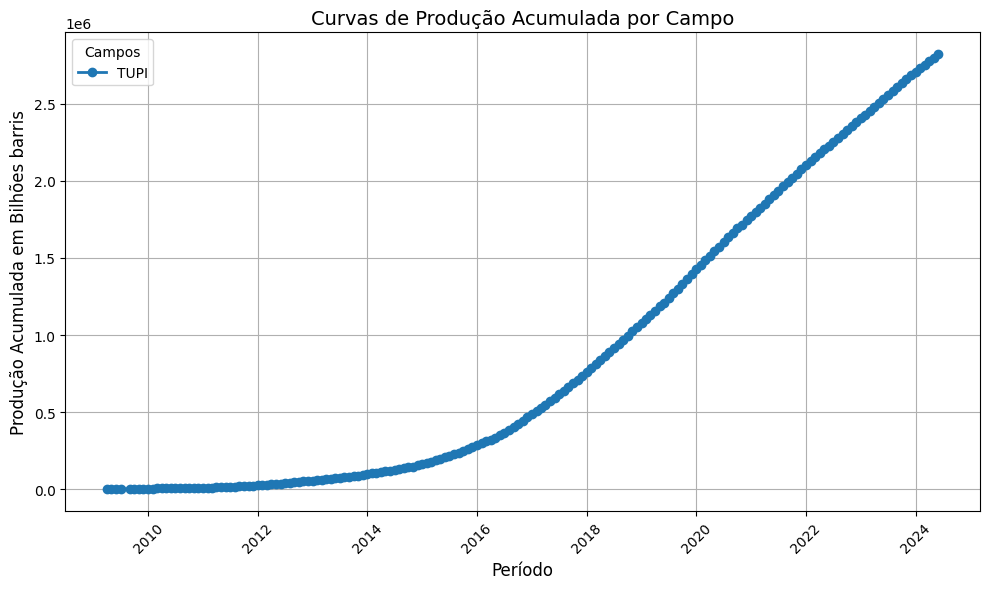

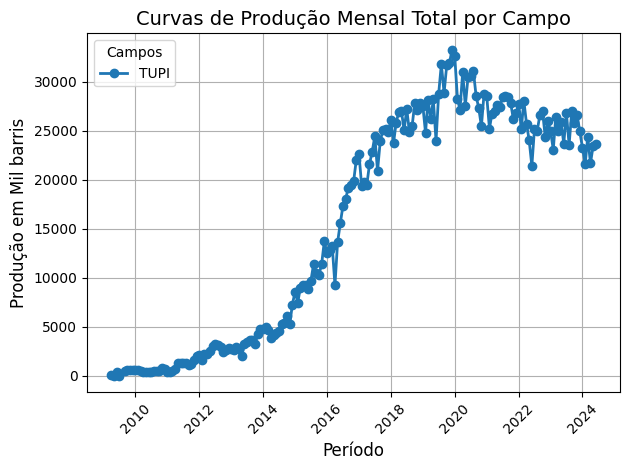

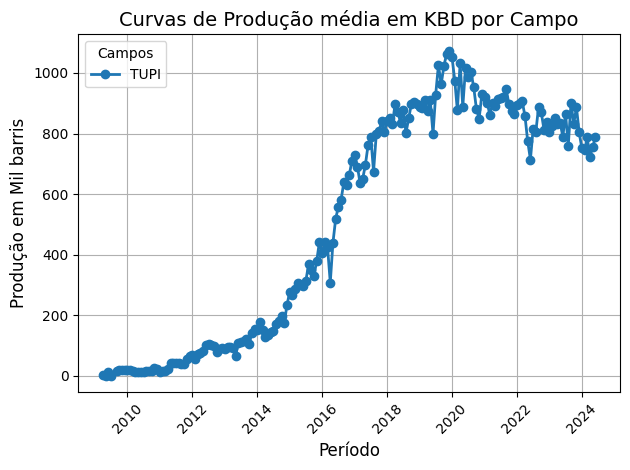

In [ ]:
# Criar um gráfico de produção acumulada para TUPI
plt.figure(figsize=(10, 6))

# Plotar a produção acumulada
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['producao_acumulada'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Acumulada por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção Acumulada em Bilhões barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar a produção total mensal
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['oleo_kb_total_mes'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Mensal Total por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção em Mil barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar a produção média em KBD mensalmente
for campo in ['TUPI']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['oleo_kbd_total'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção média em KBD por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção em Mil barris', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## MACHINE LEARNING

Nessa seção iremos treinar os modelos de Machine Learning usando as técnicas de Regressão Linear, Gradient Boosting,


Numa primeira versão do modelo iremos utilizar as features:
 - tempo em meses que o campo produz desde o primeiro óleo
 - produção de petróleo em mil barris
 - campo que produziu

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
display(df_fields_prod.head(3))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,dias_no_mes,oleo_kb_total_mes,producao_acumulada,data_inicio,tempo_total_producao_meses
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,31,176.303374,176.303374,1980-01-01,0
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,31,0.000000,0.000000,1980-01-01,0
6156,BONITO,1980-01-01,3.853138,0.0,3.853138,1.852973,0.0,1.852973,0.000000,0,Campos,31,119.447266,119.447266,1980-01-01,0


### Análise de Modelos

#### Preparação

In [ ]:
# A coluna producao corresponde de petróleo em barris de cada campo em cada período e será o alvo de nosso estudo
df_fields = df_fields_prod[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total', 'producao_acumulada']]

# Filtrar os campos que produzem abaixo do limiar
campos_filtrados = df_fields[df_fields['producao_acumulada'] >= limiar_producao]['campo']

# Filtrar o DataFrame original para manter apenas os campos com produção alta
df_fields = df_fields[df_fields['campo'].isin(campos_filtrados)]

print(campos_filtrados)

# Agrupar por 'campo' e pegar o valor máximo de 'producao_acumulada'
#df_max_producao_acumulada = df_fields_filtrado.groupby('campo')['producao_acumulada'].max().reset_index()

# Exibir a tabela com o valor máximo de produção acumulada para cada campo
#display(df_max_producao_acumulada.sort_values(by='producao_acumulada', ascending=False).reset_index().head(100))

# Removendo a coluna de produção acumulada pois não sera usada
df_fields = df_fields[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']]

15432            GAROUPA
15433            GAROUPA
15434            GAROUPA
15435            GAROUPA
15436            GAROUPA
              ...       
29626    TUBARÃO MARTELO
29808               TUPI
30481             URUGUÁ
30904           VERMELHO
31643             VOADOR
Name: campo, Length: 13426, dtype: object


In [ ]:
# Passo 1: Gerar a sequência completa de meses para cada campo (de 1 até o máximo)
df_complete = []

for campo in df_fields['campo'].unique():
    df_campo = df_fields[df_fields['campo'] == campo]

    # Gerar todos os meses do 1 até o máximo de 'tempo_total_producao_meses'
    meses_completos = pd.DataFrame({'tempo_total_producao_meses': np.arange(1, df_campo['tempo_total_producao_meses'].max() + 1)})

    # Passo 2: Mesclar com o df original para garantir que todos os meses estão presentes
    df_campo_completo = pd.merge(meses_completos, df_campo[['campo', 'tempo_total_producao_meses', 'oleo_kbd_total']],
                                  how='left', on='tempo_total_producao_meses')

    # Passo 3: Preencher valores ausentes com zero
    df_campo_completo['oleo_kbd_total'] = df_campo_completo['oleo_kbd_total'].fillna(0)

    # Adicionar o campo identificador para manter a informação do campo
    df_campo_completo['campo'] = campo

    # Adicionar à lista completa
    df_complete.append(df_campo_completo)

# Concatenar os DataFrames de todos os campos
df_fields = pd.concat(df_complete, ignore_index=True)

# Exibir as primeiras linhas do DataFrame completo
display(df_fields.head(3))

,tempo_total_producao_meses,campo,oleo_kbd_total
0,1,BONITO,3.766967
1,2,BONITO,3.007158
2,3,BONITO,2.124698


In [ ]:
# Listas para armazenar os DataFrames de treino e teste
list_dfs_train = []
list_dfs_test = []

# Iterar sobre cada campo
for campo in df_fields['campo'].unique():

  # Filtrar os dados para o campo atual
  df_campo = df_fields[df_fields['campo'] == campo]

  # Ordenar por 'tempo_total_producao_meses' (ou 'periodo' se necessário)
  df_campo_sorted = df_campo.sort_values(by='tempo_total_producao_meses')

  # Determinar o índice de corte para 70% de dados para treino
  train_size = int(len(df_campo_sorted) * 0.7)

  # Separar os dados em treino (70%) e teste (30%)
  df_train = df_campo_sorted.iloc[:train_size]
  df_test = df_campo_sorted.iloc[train_size:]

  # Adicionar os DataFrames de treino e teste nas respectivas listas
  list_dfs_train.append(df_train)
  list_dfs_test.append(df_test)

  """
  # COMENTADO PARA AUMENTO DE PERFORMANCE DE EXECUÇÃO
  # Plotando os dados de treino e teste
  plt.figure(figsize=(10, 6))

  # Plot para dados de treino
  plt.plot(df_train['tempo_total_producao_meses'], df_train['oleo_kbd_total'],
            color='red', label='Treino', alpha=0.6)

  # Plot para dados de teste
  plt.plot(df_test['tempo_total_producao_meses'], df_test['oleo_kbd_total'],
            color='purple', label='Teste', alpha=0.6)

  # Títulos e rótulos
  plt.title(f'Campo: {campo} - Dados de Treino e Teste', fontsize=14)
  plt.xlabel('Tempo Total de Produção (Meses)', fontsize=12)
  plt.ylabel('Produção de Óleo (KBD)', fontsize=12)

  # Exibindo a legenda
  plt.legend()

  # Exibindo o gráfico
  plt.show()

  """

In [ ]:
# Concatenar os DataFrames de treino e teste
df_train_final = pd.concat(list_dfs_train, ignore_index=True)
df_test_final = pd.concat(list_dfs_test, ignore_index=True)

# Mostrar os DataFrames finais para treino e teste
print("Dados de Treinamento:", df_train_final.shape)
print("Dados de Teste:", df_test_final.shape)
display(df_train_final.head(3))
display(df_test_final.head(3))

Dados de Treinamento: (13580, 3)
Dados de Teste: (5860, 3)


,tempo_total_producao_meses,campo,oleo_kbd_total
0,1,BONITO,3.766967
1,2,BONITO,3.007158
2,3,BONITO,2.124698


,tempo_total_producao_meses,campo,oleo_kbd_total
0,374,BONITO,5.159844
1,375,BONITO,4.697849
2,376,BONITO,3.673891


#### One-hot Encoding

In [ ]:
# Inicializando o OneHotEncoder (drop_first=True para evitar multicolinearidade)
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustando o encoder com os dados de treino (ajustando para as categorias presentes em df_train_final)
X_train_encoded = encoder.fit_transform(df_train_final[['campo']])

# Transformando o conjunto de teste com o encoder ajustado (usando o mesmo encoding do treino)
X_test_encoded = encoder.transform(df_test_final[['campo']])

# Convertendo os resultados em DataFrames para facilitar a manipulação
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['campo']))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['campo']))

# Adicionando de volta as colunas numéricas (tempo_total_producao_meses) aos datasets de treino e teste
X_train = pd.concat([df_train_final[['tempo_total_producao_meses']].reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([df_test_final[['tempo_total_producao_meses']].reset_index(drop=True), X_test_encoded_df], axis=1)

# Separando a variável target 'oleo_kbd_total' (ou qualquer outra variável alvo)
y_train = df_train_final['oleo_kbd_total']
y_test = df_test_final['oleo_kbd_total']

#### Treinamento de modelos

##### 1 Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Treinando o modelo Linear Regression
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = model_linear.predict(X_test)

# Calculando as métricas de qualidade do modelo
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f'MAE: {mae_linear}')
print(f'MSE: {mse_linear}')
print(f'R2: {r2_linear}')

MAE: 39.21170284955477
MSE: 4797.868166805131
R2: 0.48012556050809396


In [ ]:
# Filtrando o DataFrame para o campo específico
df_campo = df_fields[df_fields['campo'] == campo]
display(df_campo.head(3))

# Encontrando o período máximo para esse campo
periodo_maximo = df_campo['tempo_total_producao_meses'].max()
print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

# Definindo o tempo inicial (último mês registrado + 1)
tempo_total_producao_meses = periodo_maximo + 1

,tempo_total_producao_meses,campo,oleo_kbd_total
13311,1,MARLIM SUL,8.339476
13312,2,MARLIM SUL,7.972397
13313,3,MARLIM SUL,9.165045


O período máximo para o campo MARLIM SUL é: 362


O período máximo para o campo MARLIM SUL é: 362


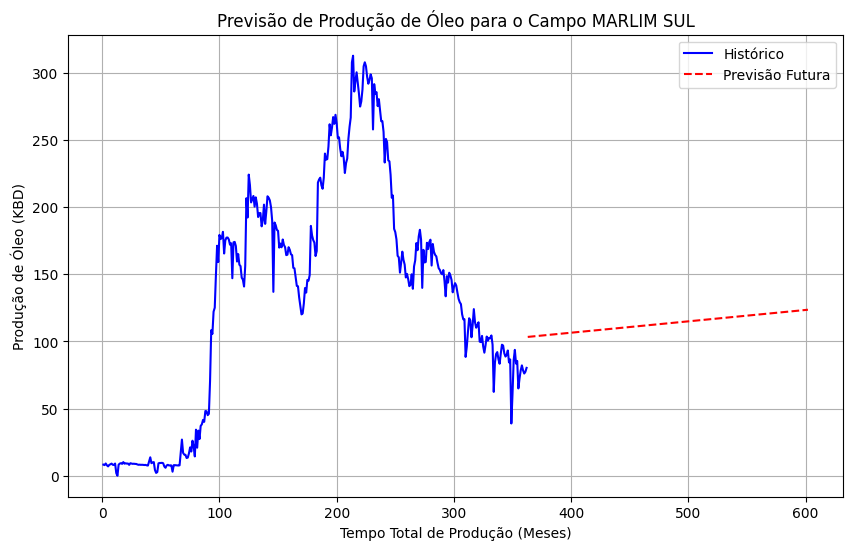

Previsão de produção para o campo MARLIM SUL no mês 602: 123.58 KBD


In [ ]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_linear.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

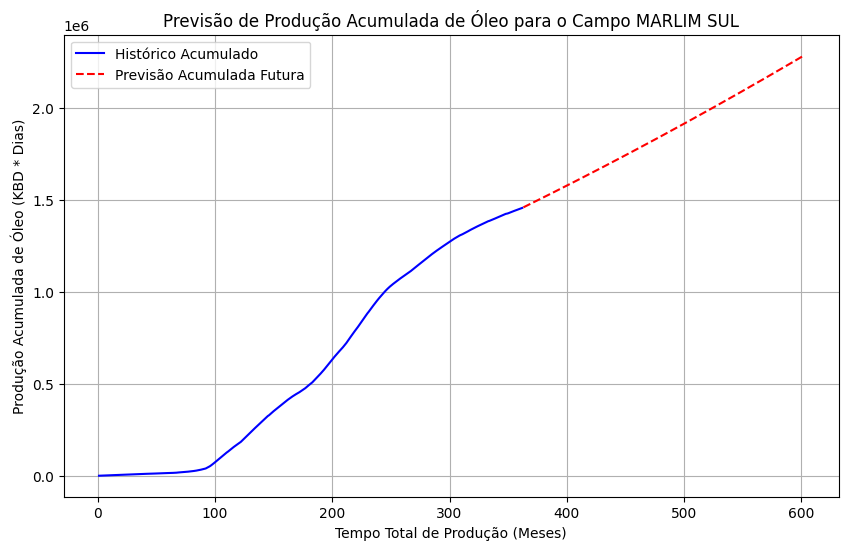

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 2286167.38 KBD * Dias


In [ ]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo (KBD * Dias)')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} KBD * Dias')


##### 2 Gradient Boosting

In [ ]:
from xgboost import XGBRegressor

"""best_params = {
    'n_estimators': 100,
    'max_depth': 7,
    'learning_rate': 0.2,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'random_state': 42
}"""

# Criando o modelo com os melhores parâmetros
model_gboost = XGBRegressor(random_state=42)

model_gboost.fit(X_train, y_train)

y_pred = model_gboost.predict(X_test)

mae_gboost = mean_absolute_error(y_test, y_pred)
mse_gboost = mean_squared_error(y_test, y_pred)
r2_gboost = r2_score(y_test, y_pred)

print(f'MAE: {mae_gboost}')
print(f'MSE: {mse_gboost}')
print(f'R2: {r2_gboost}')

MAE: 17.57551139533997
MSE: 1843.1341828386016
R2: 0.8002866446308281


O período máximo para o campo MARLIM SUL é: 362


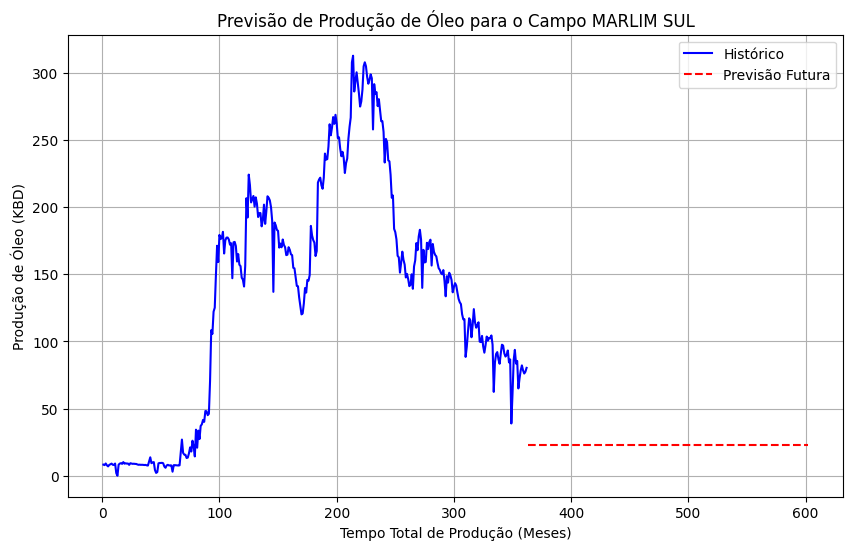

Previsão de produção para o campo MARLIM SUL no mês 602: 22.68 KBD


In [ ]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_gboost.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

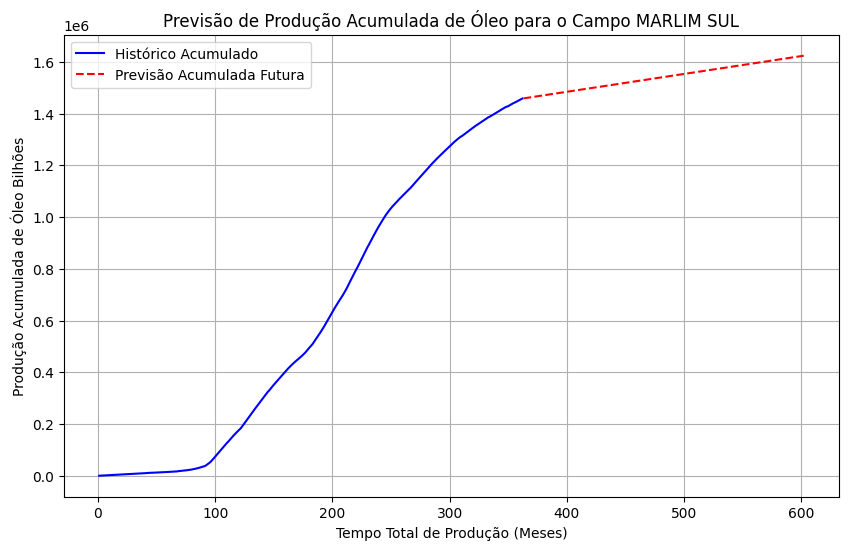

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 1623324.88 de Barris


In [ ]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo Bilhões')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} de Barris')


##### 3 LightGBM

In [ ]:
from lightgbm import LGBMRegressor

# Criando e treinando o modelo LightGBM
model_lgbm = LGBMRegressor(random_state=42)
model_lgbm.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_lgbm = model_lgbm.predict(X_test)

# Avaliando o modelo
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'MAE: {mae_lgbm}')
print(f'MSE: {mse_lgbm}')
print(f'R2: {r2_lgbm}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 13580, number of used features: 64
[LightGBM] [Info] Start training from score 35.913347
MAE: 19.043638608973172
MSE: 1899.1918117159962
R2: 0.7942125034959151


O período máximo para o campo MARLIM SUL é: 362


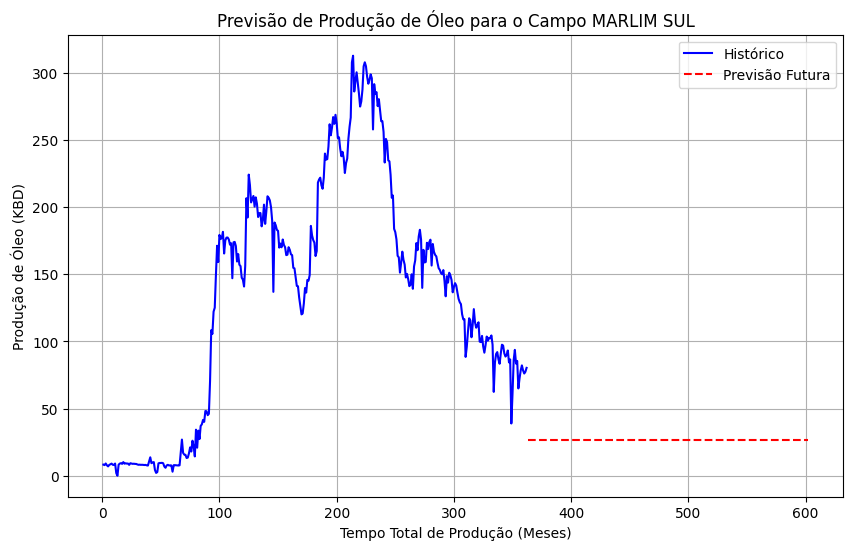

Previsão de produção para o campo MARLIM SUL no mês 602: 26.92 KBD


In [ ]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_lgbm.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

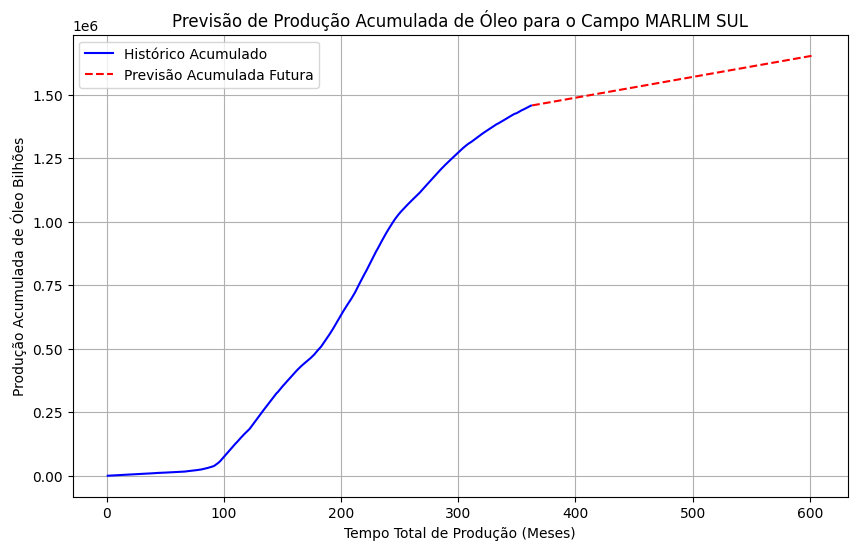

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 1654282.92 de Barris


In [ ]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo Bilhões')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} de Barris')


##### 4 Rede Neural

In [ ]:
from sklearn.neural_network import MLPRegressor

# Criando e treinando o modelo de rede neural
model_ann = MLPRegressor(hidden_layer_sizes=(100,), max_iter=600, learning_rate_init=0.001, learning_rate='adaptive', random_state=42)

model_ann.fit(X_train, y_train)

# Fazendo previsões
y_pred_ann = model_ann.predict(X_test)

# Avaliando o modelo
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)
print(f'MAE: {mae_ann}')
print(f'MSE: {mse_ann}')
print(f'R2: {r2_ann}')

MAE: 21.943940223345734
MSE: 2262.535193611356
R2: 0.7548423227325436


O período máximo para o campo MARLIM SUL é: 362


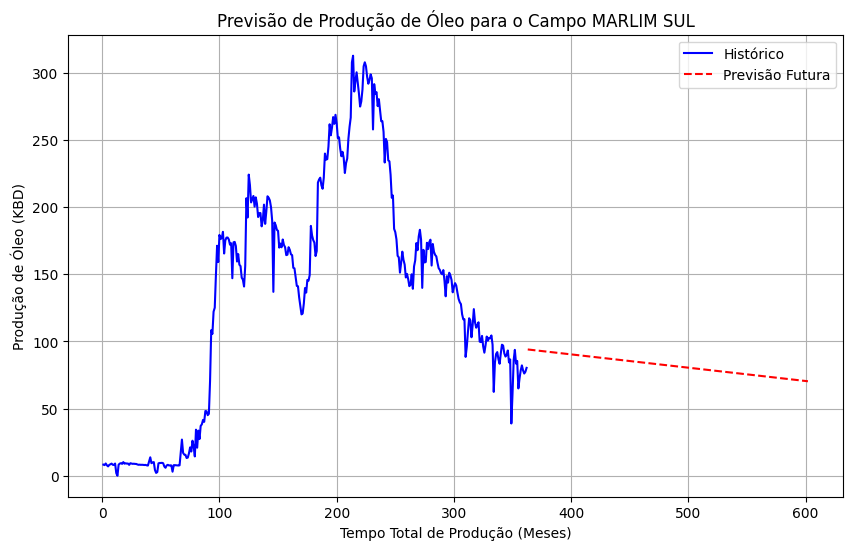

Previsão de produção para o campo MARLIM SUL no mês 602: 70.36 KBD


In [ ]:
# Codificando a variável 'campo' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo']]  # Features: tempo de produção e campo
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando 'campo' com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
campos = df_fields['campo'].unique()  # Identificando os campos únicos

for campo in [campo]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro  # Repetindo o campo para todos os meses
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Fazendo a previsão para os próximos 120 meses
    y_futuro = model_ann.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro, label='Previsão Futura', color='red', linestyle='--')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.xlabel('Tempo Total de Produção (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibindo o resultado da previsão para o último mês
    print(f'Previsão de produção para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_futuro[-1]:.2f} KBD')

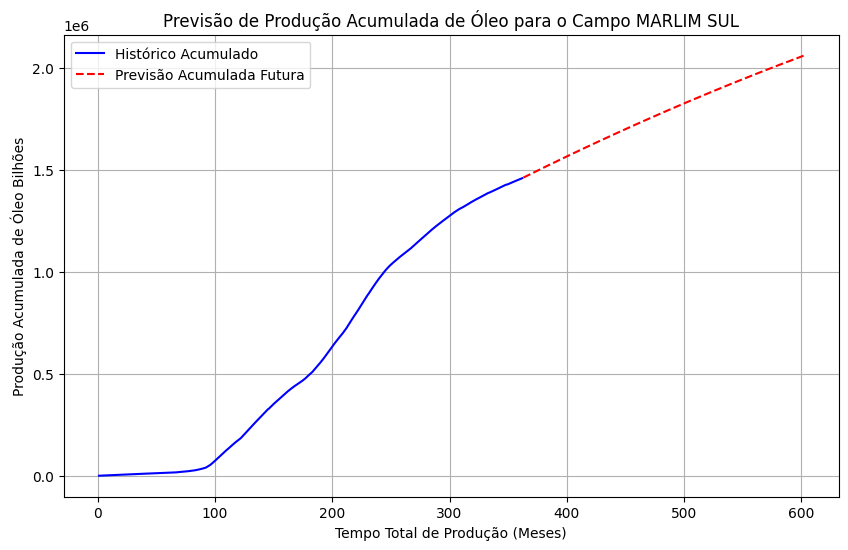

Previsão de produção acumulada para o campo MARLIM SUL no mês 602: 2057802.09 de Barris


In [ ]:
# Convertendo a produção para a base de dias
df_campo['oleo_kbd_total'] = df_campo['oleo_kbd_total'] * 30.42  # Convertendo para dias

# Calculando a produção acumulada histórica (para os meses históricos)
df_campo['oleo_kbd_total_acumulado'] = df_campo['oleo_kbd_total'].cumsum()

# Garantindo que a produção acumulada futura seja contínua (sem salto)
# A produção acumulada futura começa a partir da última produção acumulada histórica
y_acumulada_futura = y_futuro.cumsum() * 30.42  # Produção acumulada futura em dias
y_acumulada_futura = y_acumulada_futura + df_campo['oleo_kbd_total_acumulado'].iloc[-1]  # Somando ao último valor acumulado histórico

# Exibindo o gráfico com o histórico e as previsões acumuladas futuras de forma contínua
plt.figure(figsize=(10, 6))
plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total_acumulado'], label='Histórico Acumulado', color='blue')
plt.plot(X_futuro['tempo_total_producao_meses'], y_acumulada_futura, label='Previsão Acumulada Futura', color='red', linestyle='--')
plt.title(f'Previsão de Produção Acumulada de Óleo para o Campo {campo}')
plt.xlabel('Tempo Total de Produção (Meses)')
plt.ylabel('Produção Acumulada de Óleo Bilhões')
plt.legend()
plt.grid(True)
plt.show()

# Exibindo o resultado da previsão acumulada para o último mês
print(f'Previsão de produção acumulada para o campo {campo} no mês {tempo_total_producao_meses + num_meses_futuro - 1}: {y_acumulada_futura[-1]:.2f} de Barris')


#### Comparação dos modelos

In [ ]:
# Criando um dicionário com os resultados dos modelos
results = {
    'Modelo': ['LGBM', 'Gradient Boosting', 'Regressão Linear', 'Redes Neurais'],
    'MAE': [mae_lgbm, mae_gboost, mae_linear, mae_ann],
    'MSE': [mse_lgbm, mse_gboost, mse_linear, mse_ann],
    'R2': [r2_lgbm, r2_gboost, r2_linear, r2_ann]
}

# Criando um DataFrame com os resultados
df_results = pd.DataFrame(results)

# Exibindo o DataFrame
print(df_results)

              Modelo        MAE          MSE        R2
0               LGBM  19.043639  1899.191812  0.794213
1  Gradient Boosting  17.575511  1843.134183  0.800287
2   Regressão Linear  39.211703  4797.868167  0.480126
3      Redes Neurais  21.943940  2262.535194  0.754842


### Otimização - Feature Engineering

In [ ]:
# Engenharia de features

# Features para o modelo
lista_de_features = ['tempo_total_producao_meses', 'campo', 'oleo_kbd_total',
                     'gas_natural_mmscf_total_total', 'agua_kbd_total']

# Filtragem de campos com produção acumulada >= limiar
limiar_producao = 1 * 1e3  # Exemplo de limiar
df_fields = df_fields_prod[df_fields_prod['producao_acumulada'] >= limiar_producao][lista_de_features]

# Preencher meses ausentes
df_fields = completar_meses(df_fields)

# Separar os dados
df_train, df_test = dividir_treino_teste(df_fields)

# Aplicando o One-Hot encoding na coluna 'campo'
X_train, X_test, y_train, y_test = aplicar_one_hot_encoding(df_train, df_test)

#### 2.b Gradient Boosting

In [ ]:
# Criar e configurar o modelo Gradient Boosting
model_gb = XGBRegressor(random_state=42)

# Treinar o modelo
model_gb.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model_gb.predict(X_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Exibir métricas de avaliação
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 6.05
MSE: 428.53
R²: 0.93


#### 3.b LightGBM

In [ ]:
from lightgbm import LGBMRegressor

# Criando e treinando o modelo LightGBM
model_lgbm = LGBMRegressor(random_state=42)
model_lgbm.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_lgbm = model_lgbm.predict(X_test)

# Avaliando o modelo
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'MAE: {mae_lgbm}')
print(f'MSE: {mse_lgbm}')
print(f'R2: {r2_lgbm}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 105
[LightGBM] [Info] Start training from score 24.215925
MAE: 7.490060105441298
MSE: 556.2055318703258
R2: 0.9114459027172667


#### 4.b Rede Neural

In [ ]:
# Criando e treinando o modelo de rede neural com múltiplas camadas
model_ann_multi = MLPRegressor(hidden_layer_sizes=(100,),
                               max_iter=600,
                               learning_rate_init=0.001,
                               learning_rate='adaptive',
                               random_state=42)

# Treinando o modelo
model_ann_multi.fit(X_train, y_train)

# Fazendo previsões
y_pred_ann_multi = model_ann_multi.predict(X_test)

# Avaliando o modelo
mae_ann_multi = mean_absolute_error(y_test, y_pred_ann_multi)
mse_ann_multi = mean_squared_error(y_test, y_pred_ann_multi)
r2_ann_multi = r2_score(y_test, y_pred_ann_multi)

# Exibindo as métricas
print(f'MAE (Multilayer): {mae_ann_multi}')
print(f'MSE (Multilayer): {mse_ann_multi}')
print(f'R² (Multilayer): {r2_ann_multi}')

MAE (Multilayer): 7.724172331116271
MSE (Multilayer): 525.0509565434209
R² (Multilayer): 0.9164060570778748


#### Comparação visual dos modelos

O período máximo para o campo TUPI é: 182


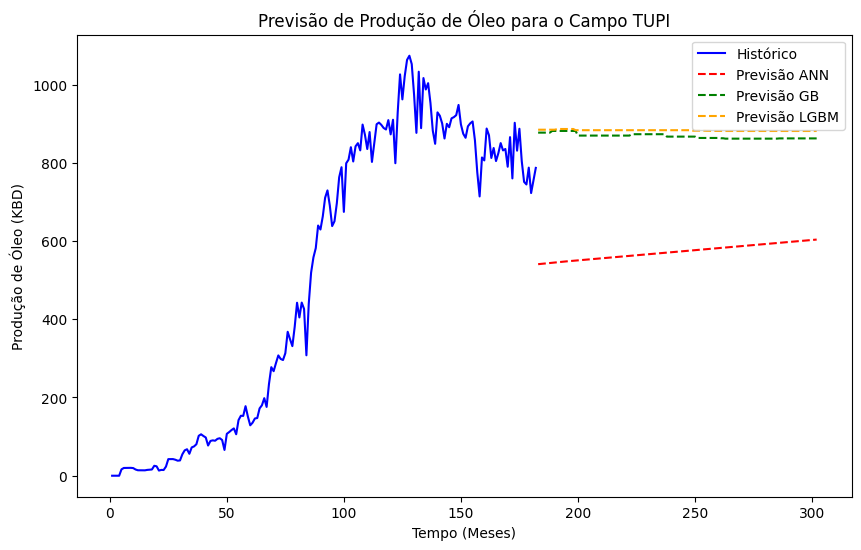

O período máximo para o campo MARLIM é: 399


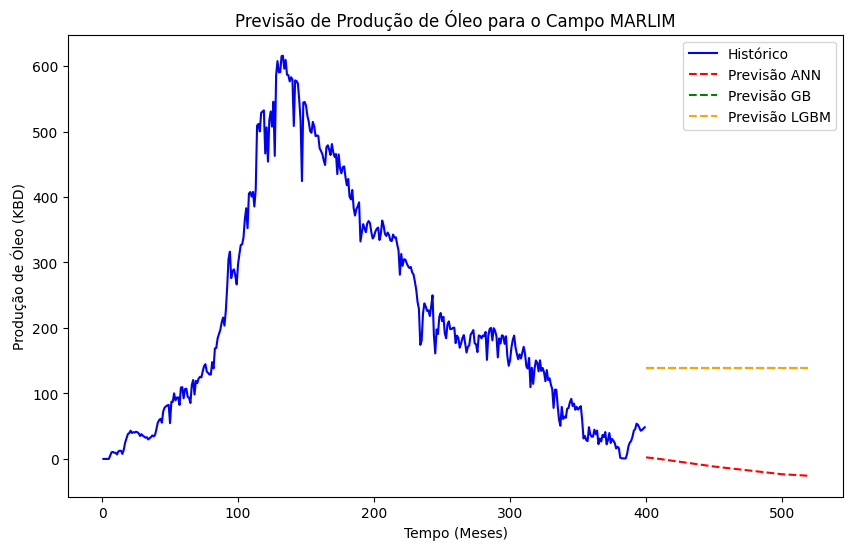

O período máximo para o campo RONCADOR é: 305


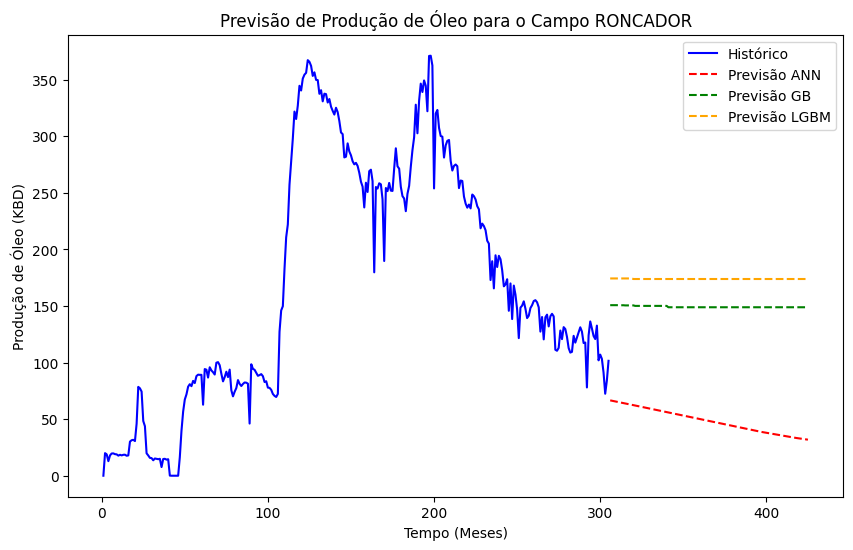

O período máximo para o campo MARLIM SUL é: 362


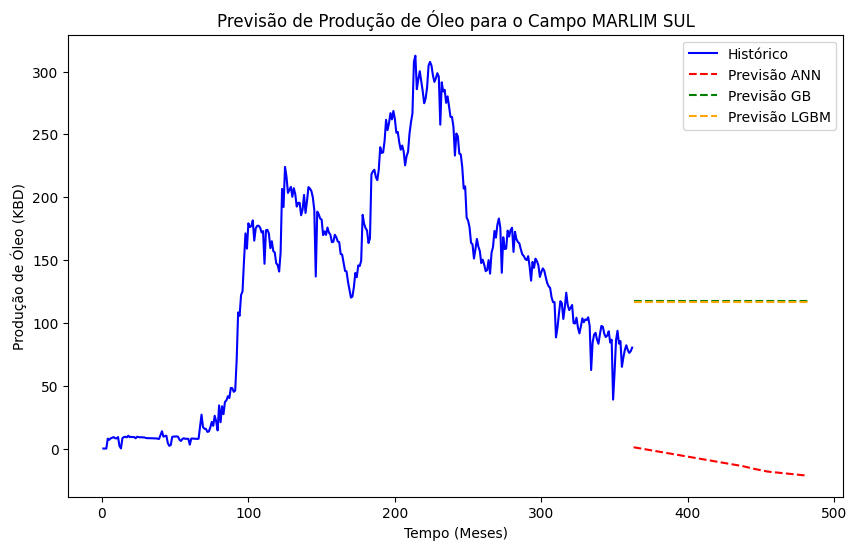

O período máximo para o campo ALBACORA é: 440


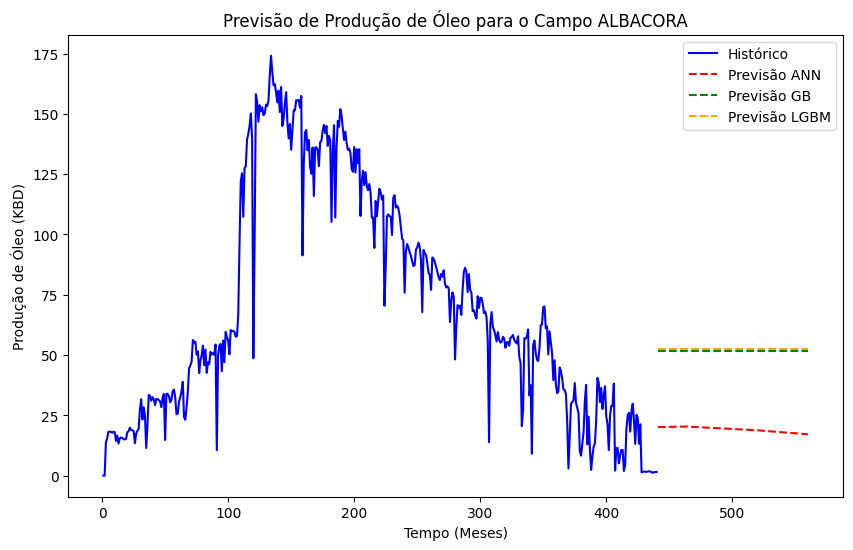

O período máximo para o campo JUBARTE é: 260


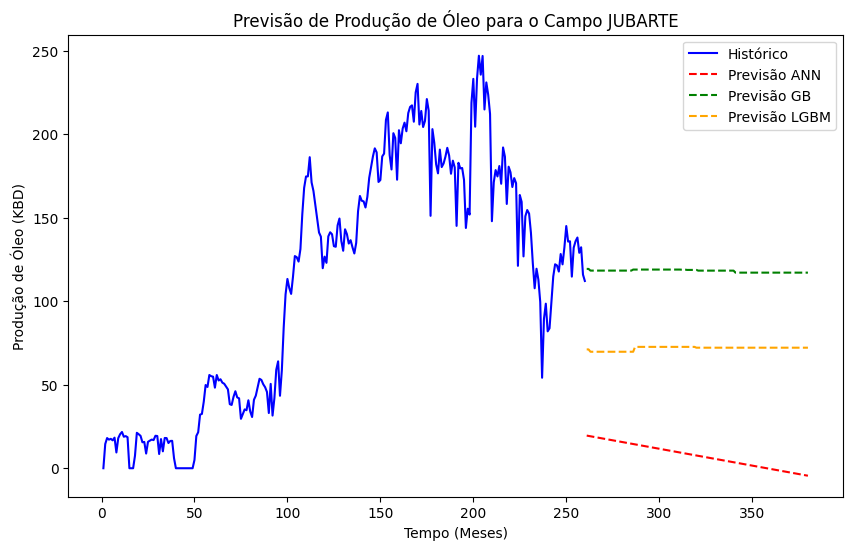

O período máximo para o campo SAPINHOÁ é: 162


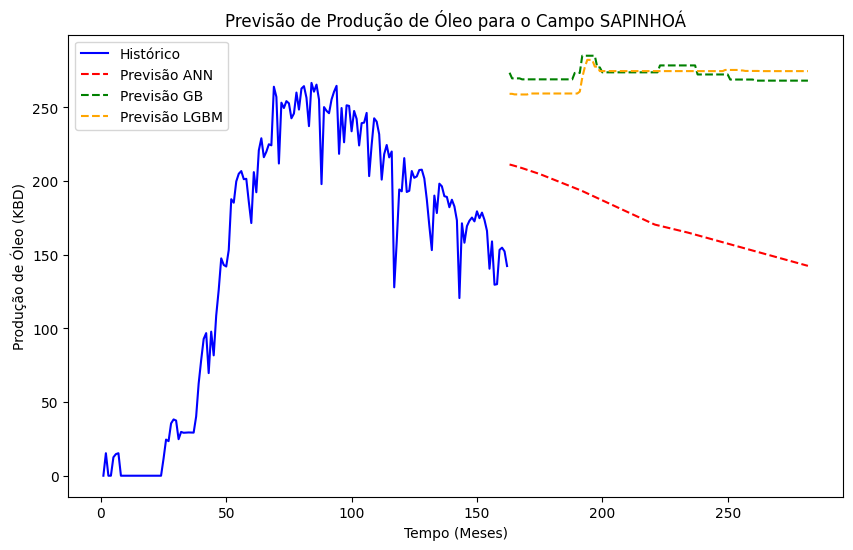

O período máximo para o campo BARRACUDA é: 321


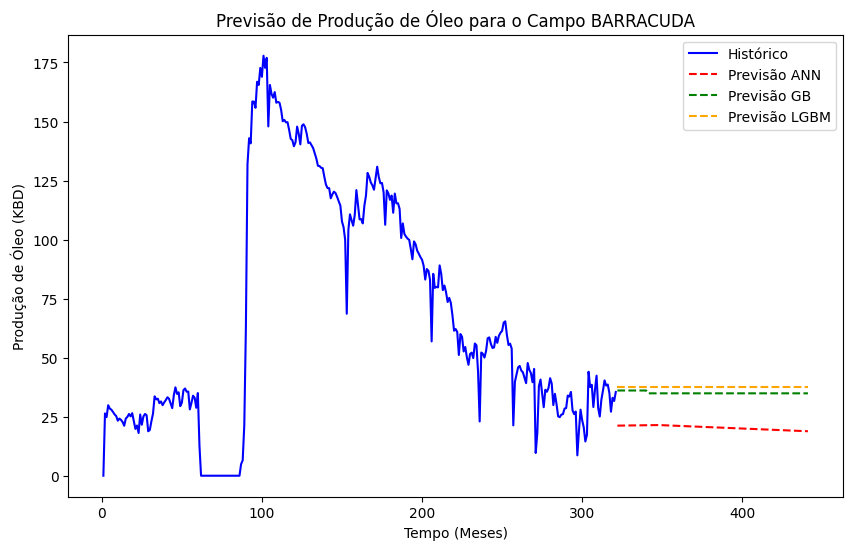

O período máximo para o campo BÚZIOS é: 128


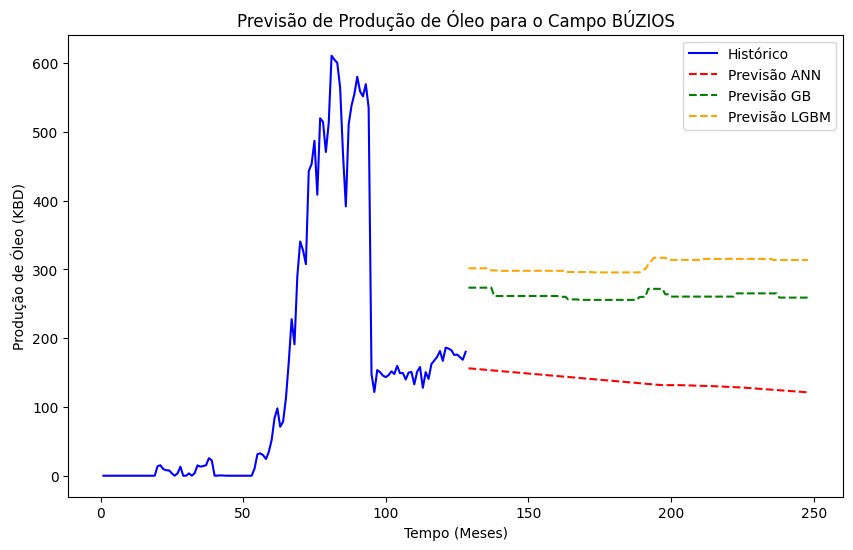

O período máximo para o campo MARLIM LESTE é: 286


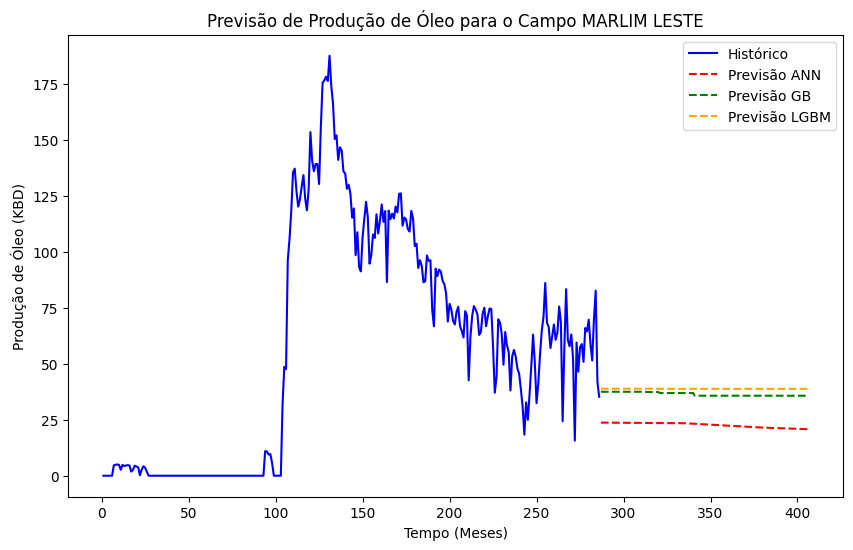

In [ ]:
#campos = ['TUPI']
# campos = df_fields['campo'].unique()

# Calculando a soma de 'oleo_kbd_total' por 'campo'
campos_ordenados = df_fields.groupby('campo')['oleo_kbd_total'].sum().sort_values(ascending=False)

# Criando a lista de campos ordenados de acordo com a soma de 'oleo_kbd_total'
campos_lista_ordenada = campos_ordenados.index.tolist()

# Codificando as variáveis 'campo', 'gas_natural_mmscf_total_total', e 'agua_kbd_total' com One-Hot Encoding
X = df_fields[['tempo_total_producao_meses', 'campo', 'gas_natural_mmscf_total_total', 'agua_kbd_total']]  # Adicionando mais features
y = df_fields['oleo_kbd_total']  # Alvo: produção de óleo

# Codificando variáveis categóricas e contínuas com One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Gerando previsões para os próximos 120 meses para cada campo
for campo in campos_lista_ordenada[:10]:
    # Filtrando o dataframe para o campo específico
    df_campo = df_fields[df_fields['campo'] == campo]

    # Encontrando o período máximo para esse campo
    periodo_maximo = df_campo['tempo_total_producao_meses'].max()
    print(f"O período máximo para o campo {campo} é: {periodo_maximo}")

    # Criando os dados para os próximos 120 meses
    num_meses_futuro = 120
    tempo_total_producao_meses = periodo_maximo + 1  # Tempo inicial (último mês + 1)

    # Criando os dados para prever os próximos 120 meses
    X_futuro = pd.DataFrame({
        'tempo_total_producao_meses': [tempo_total_producao_meses + i for i in range(num_meses_futuro)],  # 120 meses
        'campo': [campo] * num_meses_futuro,  # Repetindo o campo para todos os meses
        'gas_natural_mmscf_total_total': [df_campo['gas_natural_mmscf_total_total'].mean()] * num_meses_futuro,  # Assumindo valores médios para outras features
        'agua_kbd_total': [df_campo['agua_kbd_total'].mean()] * num_meses_futuro  # Assumindo valores médios para outras features
    })

    # Aplicando o One-Hot Encoding para as variáveis
    X_futuro = pd.get_dummies(X_futuro, drop_first=True)

    # Garantindo que as colunas de X_futuro correspondam exatamente às de X (no caso da codificação)
    X_futuro = X_futuro.reindex(columns=X.columns, fill_value=0)

    # Usando o modelo treinado para fazer a previsão para os próximos 120 meses com a rede neural
    y_futuro_ann = model_ann_multi.predict(X_futuro)

    # Usando o modelo treinado para fazer a previsão para os próximos 120 meses com o modelo de Gradient Boosting
    y_futuro_gb = model_gb.predict(X_futuro)

    # Usando o modelo treinado para fazer a previsão para os próximos 120 meses com o modelo LightGBM
    y_futuro_lgbm = model_lgbm.predict(X_futuro)

    # Exibindo o gráfico com o histórico e as previsões futuras
    plt.figure(figsize=(10, 6))
    plt.plot(df_campo['tempo_total_producao_meses'], df_campo['oleo_kbd_total'], label='Histórico', color='blue')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro_ann, label='Previsão ANN', color='red', linestyle='--')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro_gb, label='Previsão GB', color='green', linestyle='--')
    plt.plot(X_futuro['tempo_total_producao_meses'], y_futuro_lgbm, label='Previsão LGBM', color='orange', linestyle='--')
    plt.xlabel('Tempo (Meses)')
    plt.ylabel('Produção de Óleo (KBD)')
    plt.title(f'Previsão de Produção de Óleo para o Campo {campo}')
    plt.legend()
    plt.show()

#### Comparação dos modelos

In [ ]:
# Criando um dicionário com os resultados dos modelos
results = {
    'Modelo': ['Gradient Boosting', 'LGBM', 'Redes Neurais'],
    'MAE': [mae, mae_lgbm, mae_ann_multi],
    'MSE': [mse, mse_lgbm, mse_ann_multi],
    'R2': [r2, r2_lgbm, r2_ann_multi]
}

# Criando um DataFrame com os resultados
df_results_v2 = pd.DataFrame(results)
display(df_results_v2)

,Modelo,MAE,MSE,R2
0,Gradient Boosting,6.050401,428.534221,0.931773
1,LGBM,7.490060,556.205532,0.911446
2,Redes Neurais,7.724172,525.050957,0.916406


### Otimização - Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#### 3.c LightGBM

In [ ]:
# Definindo o modelo base
model_lgbm = LGBMRegressor(random_state=42)

# Definindo o espaço de busca dos hiperparâmetros
param_grid = {
    'n_estimators': [100],  # Número de árvores
    'learning_rate': [0.1],  # Taxa de aprendizado
    'max_depth': [-1],  # Profundidade máxima da árvore
    'num_leaves': [31],  # Número de folhas por árvore
    'min_child_samples': [20],  # Número mínimo de amostras por folha
    'subsample': [1.0],  # Fração das amostras para treinamento
    'colsample_bytree': [1.0]  # Fração das features para treinamento
}

# best {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}

# Aplicando GridSearchCV
grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Treinando o modelo com a busca em grade
grid_search.fit(X_train, y_train)

# Obtendo os melhores parâmetros
best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

# Criando o modelo com os melhores parâmetros encontrados
best_model = grid_search.best_estimator_

# Fazendo previsões no conjunto de teste com o melhor modelo
y_pred_lgbm = best_model.predict(X_test)

# Avaliando o modelo
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'MAE: {mae_lgbm}')
print(f'MSE: {mse_lgbm}')
print(f'R2: {r2_lgbm}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 105
[LightGBM] [Info] Start training from score 24.215925
Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}
MAE: 7.490060105441298
MSE: 556.2055318703258
R2: 0.9114459027172667


#### 4.c Rede Neural

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definindo o modelo base
model_ann_multi = MLPRegressor(random_state=42)

# Melhores parâmetros da rede neural: {'activation': 'relu', 'alpha': 0.0001,
#                                     'batch_size': 'auto', 'hidden_layer_sizes': (50,),
#                                     'learning_rate_init': 0.001,
#                                     'max_iter': 400, 'solver': 'adam'}

# Definindo o espaço de busca dos hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100, 100)],  # Tamanho das camadas ocultas
    'max_iter': [200],  # Número máximo de iterações
    'learning_rate_init': [0.001],  # Taxa de aprendizado inicial
    'activation': ['relu'],  # Função de ativação
    'solver': ['adam'],  # Algoritmo de otimização
    'alpha': [0.0001],  # Regularização L2
    'batch_size': ['auto']  # Tamanho do lote
}

"""
padrão
{
    'hidden_layer_sizes': (100,),  # Uma camada com 100 neurônios
    'max_iter': 200,               # 200 iterações
    'learning_rate_init': 0.001,   # Taxa de aprendizado inicial de 0.001
    'activation': 'relu',          # Função de ativação ReLU
    'solver': 'adam',              # Algoritmo de otimização Adam
    'alpha': 0.0001,               # Regularização L2 com coeficiente 0.0001
    'batch_size': 'auto',          # Tamanho do lote automático
    'random_state': None           # Sem controle de aleatoriedade
}
"""

# Aplicando GridSearchCV
grid_search_ann = GridSearchCV(estimator=model_ann_multi, param_grid=param_grid,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Treinando o modelo com a busca em grade
grid_search_ann.fit(X_train, y_train)

# Obtendo os melhores parâmetros
best_params_ann = grid_search_ann.best_params_
print(f"Melhores parâmetros da rede neural: {best_params_ann}")

# Criando o modelo com os melhores parâmetros encontrados
best_model_ann = grid_search_ann.best_estimator_

# Fazendo previsões no conjunto de teste com o melhor modelo
y_pred_ann_multi = best_model_ann.predict(X_test)

# Avaliando o modelo
mae_ann_multi = mean_absolute_error(y_test, y_pred_ann_multi)
mse_ann_multi = mean_squared_error(y_test, y_pred_ann_multi)
r2_ann_multi = r2_score(y_test, y_pred_ann_multi)

# Exibindo as métricas
print(f'MAE (Multilayer): {mae_ann_multi}')
print(f'MSE (Multilayer): {mse_ann_multi}')
print(f'R² (Multilayer): {r2_ann_multi}')

# Avaliação de Resultados

A avaliação dos modelos foi conduzida com base em métricas apropriadas para regressão:

  - MAE (Mean Absolute Error): Média do erro absoluto entre os valores reais e previstos.
  - MSE (Mean Squared Error): Penalização de erros maiores devido ao seu quadrado.
  - R² (Coeficiente de Determinação): Medida da proporção de variação explicada pelo modelo.

SyntaxError: invalid character '²' (U+00B2) (<ipython-input-1-6b406012bfe3>, line 5)

## Prevendo a produção com os modelos selecionados

# Conclusão

## Comentários Finais

O desenvolvimento deste MVP demonstrou a viabilidade de aplicar técnicas de machine learning para prever a produção futura de petróleo em campos offshore no Brasil, com base em dados históricos fornecidos pela ANP. Este trabalho utilizou um conjunto de dados agregados por campo e implementou diferentes modelos de regressão, com destaque para LightGBM e Redes Neurais, que obtiveram os melhores desempenhos em métricas como R², MAE e MSE. Esses resultados reforçam o potencial de modelos baseados em aprendizado de máquina para fornecer previsões confiáveis no setor de óleo e gás, mesmo em um estágio inicial do projeto.

Além do desempenho técnico, o MVP destacou a importância de uma abordagem estruturada para o pré-processamento e análise exploratória dos dados, incluindo a agregação de informações distribuídas em múltiplos arquivos mensais e regionais. A padronização das variáveis foi crucial para a construção de modelos eficientes, especialmente no caso da rede neural, onde normalizar os dados contribuiu para melhorar a estabilidade e a convergência do modelo.

Os modelos também foram beneficiados pela inclusão de variáveis relacionadas à produção de gás e água, elementos que enriquecem as previsões ao capturar a complexidade da operação de campos de petróleo. Embora modelos como a Regressão Linear não tenha alcançado o mesmo nível de desempenho que os métodos baseados em boosting, eles forneceram insights valiosos sobre as relações entre as variáveis, complementando a análise geral.

Este trabalho enfatiza a importância de uma abordagem iterativa e colaborativa, integrando a ciência de dados com o conhecimento técnico do domínio para alcançar previsões robustas e confiáveis. Além disso, ele marca um passo importante no uso de dados abertos e metodologias avançadas para resolver problemas reais da indústria, contribuindo para uma gestão mais informada e eficiente dos recursos naturais. Existem oportunidades de refinar ainda mais os resultados e explorar o potencial completo das técnicas de modelagem para desafios no setor de petróleo e gás.

## Proposições futuras e sugestões de melhorias

Apesar do desempenho satisfatório, há um potencial significativo para melhorias com base nas sugestões a seguir:

1. Aumento da granularidade dos dados

  Utilizar dados em nível de poço ao invés de campo pode levar a previsões mais precisas.

  Atualmente, os dados estão agregados por campo, o que pode mascarar comportamentos individuais de poços específicos.
  Dados por poço permitem capturar nuances como taxas de produção específicas, operações de manutenção e características geológicas, enriquecendo o aprendizado dos modelos.
  Com maior granularidade, é esperado que modelos mais detalhados ajustem melhor os padrões de produção, reduzindo erros (MAE e MSE) e aumentando o R².

2. Ampliação do escopo de modelos

  Explorar novos algoritmos pode revelar abordagens que superem os modelos atuais.

  XGBoost: Considerado uma evolução do Gradient Boosting, pode oferecer melhor desempenho devido à otimização na forma como lida com árvores de decisão e regularização.
  SVM (Support Vector Machines): Pode ser útil para detectar padrões em dados mais complexos e não lineares, especialmente ao combinar diferentes variáveis no modelo.
  A adição desses modelos pode criar um comitê de modelos (ensemble) para melhorar a robustez das previsões.

3. Segmentação dos campos por estágio de produção

  Dividir os campos em estágios de produção — início, maturação e declínio — pode permitir a aplicação de modelos mais específicos a cada etapa.

  Cada estágio apresenta dinâmicas distintas, como declínios mais acentuados na fase final, que podem confundir os modelos treinados em dados mistos.
  Ao segmentar, espera-se maior adequação dos modelos e menor erro preditivo.

4. Comparação com referências conhecidas

  Integrar curvas de ARPS (Arps Decline Curves) como baseline para previsões pode ajudar na validação dos modelos.

  ARPS é amplamente utilizado na indústria e fornece previsões baseadas em modelos matemáticos bem estabelecidos.
  Ao comparar os resultados dos modelos com ARPS, é possível identificar discrepâncias e ajustar abordagens, aumentando a confiabilidade das previsões.

5. Enriquecimento dos dados

  Adicionar variáveis complementares, como dados geológicos (tipo de reservatório, porosidade, permeabilidade) e dados econômicos (preço do petróleo, investimentos no campo), pode aumentar a capacidade preditiva dos modelos.

  Dados adicionais fornecem contexto e podem explicar variações que os modelos atuais não capturam.
  O impacto esperado é a redução de outliers nos dados e maior estabilidade dos resultados.


Ao aplicar essas sugestões, espera-se:

  Redução no MAE: menor erro absoluto médio indica previsões mais consistentes.
  Redução no MSE: menor erro quadrático médio destaca menor variabilidade nos erros.
  Aumento no R²: um valor mais próximo de 1 representa explicabilidade superior dos modelos.

Com ajustes como granularidade mais detalhada, modelos mais diversificados e segmentação por estágio de produção, os melhores modelos atuais, LightGBM e Redes Neurais, têm potencial para superar o desempenho atual e se aproximar de métricas mais otimizadas e aplicabilidade na indústria.